unified => unified2
- (1), (2), (3)에 추가사항 기입 했습니다 (wordcloud, nltk 저장, Tree그려보기)
- pos filter는 찾아보니 특별한 건 없습니다. 다만 https://github.com/konlpy/konlpy/blob/master/konlpy/tag/_twitter.py 의 클래스 구조를 보니 nouns를 따로 걸러내는 건 있는 거 같아요! 그래서 wordcloud를 그릴 때 이용했습니다!
- stop words같은 건 따로 dictionay나 list를 만들어서 if~로 걸러내는 게 좋을 듯 해요. 이부분은 더 수정할게요!

In [1]:
import pandas as pd
import numpy as np
import konlpy
from konlpy.tag import Twitter
import nltk
from gensim import models
import re
import requests
import pickle

C:\Users\hyeon\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
with open('data_order.pkl', 'rb') as data:
    order = pickle.load(data)
with open('data_reason.pkl', 'rb') as data:
    reason = pickle.load(data)

In [3]:
reason[67151]

[('사건', 'Noun'),
 ('공소', 'Noun'),
 ('사실', 'Noun'),
 ('요지', 'Noun'),
 ('서울', 'Noun'),
 ('광진구', 'Noun'),
 ('자양', 'Noun'),
 ('소재', 'Noun'),
 ('머릿돌', 'Noun'),
 ('교회', 'Noun'),
 ('신축', 'Noun'),
 ('공사', 'Noun'),
 ('현장', 'Noun'),
 ('총괄', 'Noun'),
 ('하다', 'Verb'),
 ('책임자', 'Noun'),
 ('피고인', 'Noun'),
 ('공사', 'Noun'),
 ('현장', 'Noun'),
 ('주차장', 'Noun'),
 ('정화조', 'Noun'),
 ('맨홀', 'Noun'),
 ('직경', 'Noun'),
 ('cm', 'Alpha'),
 ('깊이', 'Noun'),
 ('cm', 'Alpha'),
 ('입구', 'Noun'),
 ('높이다', 'Verb'),
 ('공사', 'Noun'),
 ('작업', 'Noun'),
 ('인부', 'Noun'),
 ('오랑', 'Noun'),
 ('지시', 'Noun'),
 ('하다', 'Verb'),
 ('오랑', 'Noun'),
 ('장소', 'Noun'),
 ('발생', 'Noun'),
 ('하다', 'Verb'),
 ('있다', 'Adjective'),
 ('안전', 'Noun'),
 ('사고', 'Noun'),
 ('예방', 'Noun'),
 ('하다', 'Verb'),
 ('맨홀', 'Noun'),
 ('주위', 'Noun'),
 ('펜스', 'Noun'),
 ('설치', 'Noun'),
 ('하다', 'Verb'),
 ('외부', 'Noun'),
 ('출입', 'Noun'),
 ('통제', 'Noun'),
 ('하다', 'Verb'),
 ('뚜껑', 'Noun'),
 ('맨홀', 'Noun'),
 ('구멍', 'Noun'),
 ('견고', 'Noun'),
 ('하다', 'Verb'),
 ('덮다', 'Verb'),


In [4]:
token = [t for d in reason.values() for t in d]
print(len(token))

text = nltk.Text(token, name="NMSC")
print(text.vocab().most_common(100))

3676153
[(('하다', 'Verb'), 414963), (('피고인', 'Noun'), 87685), (('있다', 'Adjective'), 80949), (('되다', 'Verb'), 61513), (('없다', 'Adjective'), 51690), (('원심', 'Noun'), 48667), (('사실', 'Noun'), 47813), (('이유', 'Noun'), 42134), (('판결', 'Noun'), 41360), (('사건', 'Noun'), 31498), (('상고', 'Noun'), 30136), (('같다', 'Adjective'), 29817), (('아니다', 'Adjective'), 27530), (('인정', 'Noun'), 27209), (('판단', 'Noun'), 23230), (('대한', 'Noun'), 22499), (('피해자', 'Noun'), 21575), (('대하다', 'Verb'), 20154), (('행위', 'Noun'), 20051), (('공소', 'Noun'), 18703), (('받다', 'Verb'), 18481), (('선고', 'Noun'), 17086), (('증거', 'Noun'), 16564), (('보다', 'Verb'), 15858), (('이르다', 'Verb'), 15526), (('진술', 'Noun'), 15118), (('기록', 'Noun'), 14225), (('되어다', 'Verb'), 14218), (('위법', 'Noun'), 14208), (('부분', 'Noun'), 13781), (('법리', 'Noun'), 12769), (('경우', 'Noun'), 12610), (('범죄', 'Noun'), 12370), (('주장', 'Noun'), 11846), (('않다', 'Verb'), 11546), (('또는', 'Adverb'), 11322), (('파다', 'Verb'), 10630), (('위반', 'Noun'), 10359), (('오해', 'Nou

### (1) Tree 구조 그려보기 (는 저희가 갖고 있는 데이터가  완전한 문장이 아니고  토픽 워드 모델링 하는 용이라 원하는 POS만 걸러낸 상태라 트리 구조 그리는 게 의미 없긴 하지만 그냥 해봤어요..)

In [ ]:
test_tag = token[1:10]
parser_ko = nltk.RegexpParser("NP: {<Adjective>*<Noun>*}")
chunks_ko = parser_ko.parse(test_tag)
chunks_ko.draw()


### (2) plot부분 (혹시 필요할지 몰라) 따로 저장하기. 폰트는 굴림 체를 다운 받아서 사용했어요

In [ ]:
from matplotlib import pylab, font_manager, rc

font_fname = "gulim.ttc"
font_name = font_manager.FontProperties(fname=font_fname).get_name()

rc("font",family = font_name)

pylab.show = lambda: pylab.savefig("most_word.png")
text.plot(50)

# 여기서부터 doc2vec

In [5]:
sentences =[]
for i, j in reason.items():
    words =[]
    for k, l in j:
        words.append(k)
    sentences.append(models.doc2vec.LabeledSentence(words=words, tags=["SENT_{}".format(i)]))
sentences[0]

LabeledSentence(words=['상고', '이유', '판단', '하다', '피고인', '상고', '대하다', '실효', '하다', '법률', '법률', '호로', '개정', '되다', '전의', '이하', '이르다', '하다', '누구', '하다', '경우', '용도', '사용', '하다', '목적', '범죄', '경력', '자료', '또는', '수사', '경력', '자료', '이하', '범죄', '경력', '자료', '이르다', '하다', '취득', '하다', '서다', '아니다', '되다', '규정', '하다', '이르다', '위반', '하다', '범죄', '경력', '자료', '취득', '자르다', '처벌', '있다', '전과', '기록', '수사', '자료', '관리', '실효', '하다', '기준', '하다', '전과자', '정상', '사회', '복귀', '보장', '하다', '입법', '목적', '하다', '있다', '범죄', '경력', '자료', '법령', '규정', '되다', '용도', '사용', '하다', '하다', '주체', '항의', '규정', '하다', '범죄', '경력', '자료', '회보', '받다', '취득', '자로', '한정', '하다', '위반', '하다', '범죄', '경력', '자료', '취득', '자가', '법령', '규정', '되다', '용도', '범죄', '경력', '자료', '사용', '하다', '경우', '하다', '별도', '처벌', '하다', '없다', '종합', '하다', '하다', '범죄', '경력', '자료', '취득', '수사', '자료', '관리', '하다', '사람', '직무', '수사', '자료', '하다', '범죄', '경력', '조회', '하다', '사람', '직접', '취득', '하다', '경우', '한정', '되다', '없다', '원심', '판결', '이유', '법리', '기록', '비추다', '살펴보다', '원심', '채용', '증거', '종합', '하다', '피고인', '규정',

In [6]:
class LabeledLineSentence(object):
    def __init__(self, filename):
        self.filename = filename
    def __iter__(self):
        for uid, line in enumerate(open(filename)):
            yield LabeledSentence(words=line.split(), labels=['SENT_%s' % uid])
            
model = models.Doc2Vec(alpha=.025, min_alpha=.025, min_count=1)
model.build_vocab(sentences)

for epoch in range(10):
    model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)
    model.alpha -= 0.002
    model.min_alpha = model.alpha
    
model.save("my_model.doc2vec")
model_loaded = models.Doc2Vec.load('my_model.doc2vec')

In [7]:
model_loaded = models.Doc2Vec.load('my_model.doc2vec')
print(model_loaded.docvecs.most_similar(["SENT_67209"]))

[('SENT_83886', 0.6599516868591309), ('SENT_148591', 0.6588997840881348), ('SENT_109407', 0.657663106918335), ('SENT_101859', 0.649687647819519), ('SENT_97872', 0.639782726764679), ('SENT_111064', 0.6390200853347778), ('SENT_115742', 0.6374011635780334), ('SENT_85708', 0.6337199211120605), ('SENT_81494', 0.6329596042633057), ('SENT_180980', 0.6311379671096802)]


In [5]:
print(model_loaded.docvecs.most_similar(["SENT_2"]))
print(temp[0])
list(data_refd.iloc[[0], 3])
## 첫문장만 토큰화됨!
## 군 형법 제외!
## 조사, 숫자, Punctuation은 빼는걸로

TypeError: '<' not supported between instances of 'str' and 'int'

In [10]:
labeled_data = pickle.load(open('reduced_data.pkl', 'rb'))
labeled_data

,사건명,참조조문,판결요지,판례내용,판시사항,7,8,9,10,11,...,28,32,33,34,36,37,38,39,40,42
prncYd,,,,,,,,,,,,,,,,,,,,,
67151,업무상과실치사,[1] \n 형사소송법 제308조 / [2] \n 형사소송...,NaN,【피고인】 \n【상고인】 검사\n【변호인】 변호사 최기만\n【원심판결】 \n...,[1] 형사재판에 있어서 자유심증주의의 한계 및 간접증거의 증명력\n[2] 수중시체...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67258,횡령,[1]\n\n 형법 제355조 제1항,NaN,【피고인】 \n【상고인】 피고인\n【변호인】 변호사 조명원\n【원심판결】 \...,수탁자가 할인을 위하여 교부받은 약속어음을 자신의 채무변제에 충당한 경우 횡령죄의 ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
67135,사기,[1] \n 형사소송법 제308조 / [2] \n 형사소송...,NaN,【피고인】 \n【상고인】 검사\n【원심판결】 \n수원지법 2003. 2. 11....,"[1] 피고인이 수사기관이나 법정에서 공소사실을 인정하는 진술을 한 경우, 공소사실...",0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
67223,업무상과실치사,[1]\n\n 경찰관직무집행법 제10조의4 제1항\n/ [2]\n\n...,NaN,【피고인】 \n【상고인】 피고인\n【변호인】 변호사 손양곤\n【원심판결】 \...,[1] 경찰관 무기사용의 요건 및 그 판단 방법\n[2] 경찰관의 권총 사용이 허용...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71101,살인·감호청구,"[1] \n 국민의 형사재판 참여에 관한 법률 제1조, \n ...",[1] 국민의 형사재판 참여에 관한 법률에 따라 권고적 효력에 그치고 있는 배심원의...,【피고인 겸 피치료감호청구인】 \n【항 소 인】 피고인 및 검사\n【검 사】 ...,[1] 국민의 형사재판 참여에 관한 법률에 따른 배심원의 평결이 실질적 효력을 갖도...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67311,공무집행방해,"[1]\n\n 형법 제136조 제1항\n,\n\n 도...",NaN,【피고인】 \n【상고인】 검사\n【원심판결】 \n서울지법 2003. 12. 9....,적법성이 결여된 직무행위를 하는 교통경찰관에 대항하여 폭행을 가한 경우 공무집행방해...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67148,특정경제범죄가중처벌등에관한법률위반(배임)·특정경제범죄가중처벌등에관한법률위반(사기)·...,[1] \n 형법 제347조 / [2] \n 형법 제17조...,NaN,【피고인】 \n【상고인】 \n【변호인】 변호사 이재화 외 11인\n【원심판결】 ...,[1] 사기죄의 성립 요건\n[2] 금융기관에 대하여 허위의 재무제표 등을 제출하여...,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
68369,의료법위반·업무상과실치사,[1] \n 형법 제268조 / [2] \n 형법 제268조,NaN,【피 고 인】 \n【상 고 인】 피고인\n【변 호 인】 변호사 김인수\n【원심판결】...,[1] 의료사고에 있어서 의사의 과실을 인정하기 위한 요건 및 그 판단 기준\n[2...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67248,특정경제범죄가중처벌등에관한법률위반(배임)·사문서위조·위조사문서행사·공정증서 ...,"[1]\n\n 형법 제355조 제2항\n,\n\n 제3...",NaN,【피고인】 \n【상고인】 검사 및 피고인\n【변호인】 법무법인 다우 담당변...,[1] 배임죄에서 '재산상의 손해를 가한 때'의 의미와 재산상 손해 유무에 대한 판...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [11]:
model_loaded = models.Doc2Vec.load('my_model.doc2vec')
num = 67209
sim = model_loaded.docvecs.most_similar(["SENT_"+str(num)])
print(labeled_data.loc[num][:5])
for i,j in sim:
    print(i, j, labeled_data.loc[int(i.split('_')[1])]['사건명'])

사건명                                                  강간치상
참조조문    [1]\n\n         형법 제301조\n/ [2]\n\n         형법...
판결요지                                                  NaN
판례내용    【피고인】 \n【상고인】   검사\n【변호인】   변호사 노성환 (국선)\n【원심판...
판시사항    [1] 강간치상죄에 있어서의 상해의 의미\n[2] 강간치상죄의 상해에 해당한다고 볼...
Name: 67209, dtype: object
SENT_83886 0.6599516868591309 강간치상(인정된 죄명 : 강간)
SENT_148591 0.6588997840881348 강제추행
SENT_109407 0.657663106918335 강간치상,강간미수
SENT_101859 0.649687647819519 강간치상
SENT_97872 0.639782726764679 강간치상
SENT_111064 0.6390200853347778 강간치상
SENT_115742 0.6374011635780334 강간치상
SENT_85708 0.6337199211120605 강간치상(인정된죄명:준강제추행)
SENT_81494 0.6329596042633057 강제추행
SENT_180980 0.6311379671096802 강간치상,강간미수


In [5]:
labeled_data.loc[67209,"판례내용"]

'【피고인】 \n【상고인】   검사\n【변호인】   변호사 노성환 (국선)\n【원심판결】 \n서울고법 2003. 12. 24. 선고 2003노2430 판결 \n【주문】\n  상고를 기각한다.\n\n【이유】  상고이유를 본다.\n강간치상죄에 있어서의 상해는 피해자의 신체의 건강상태가 불량하게 변경되고 생활기능에 장애가 초래되는 것을 말하는 것으로서, 피해자가 입은 상처가 극히 경미하여 굳이 치료할 필요가 없고 치료를 받지 않더라도 일상생활을 하는 데 아무런 지장이 없으며 시일이 경과함에 따라 자연적으로 치유될 수 있는 정도라면, 그로 인하여 피해자의 신체의 건강상태가 불량하게 변경되었다거나 생활기능에 장애가 초래된 것으로 보기 어려워 강간치상죄에 있어서의 상해에 해당한다고 할 수 없다(\n        대법원 1994. 11. 4. 선고 94도1311 판결, \n        2003. 7. 11. 선고 2003도2313 판결 등 참조).\n      \n  원심은, 이 사건 직후 촬영한 사진에 의하면 피해자의 다리에 푸르거나 붉은 약간의 멍이 든 상처가 나타난 사실을 인정하면서도, 그 판시와 같은 사정에 비추어 볼 때 피고인의 판시 강간행위 자체 내지 그 수반된 행위에서 위 상처가 생겼다고 인정하기 어렵고, 설사 위 상처가 피고인의 강간행위 자체 내지 그 수반된 행위로 인한 것이라고 하더라도, 그 상처가 허벅지 안쪽과 다리 부위에 멍이 들었다는 것뿐이어서 이러한 정도의 상처는 경미하여 따로 치료를 받지 않아도 자연적으로 치유될 수 있고, 일상생활을 하는 데 아무런 지장이 없는 경우에 해당하여 강간치상죄에 있어서의 상해에 해당하지 아니한다고 판단하였는바, 기록에 비추어 관계 증거들을 살펴보면, 원심의 위와 같은 사실인정과 판단은 모두 정당한 것으로 수긍되고, 거기에 채증법칙을 위배하여 사실을 잘못 인정하거나, 강간치상죄에 있어서의 상해에 관한 법리를 오해한 위법이 있다고 할 수 없다.\n  그러므로 상고를 기각하기로 하여 관여 법관의 일치된 의견으로 주문과 같이

In [12]:
labeled_data.loc[102586,"사건명"]

'강도상해'

In [18]:
#전체에 대한 word2vec
#일단 문서단위에 포함된 단어로 해봄
#나 이제 피클됨 성원이 안고쳐도 될듯
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from operator import itemgetter


In [35]:
#전체에 대한 word2vec
words = []
for i, j in reason.items():
    wh =[]
    for k, l in j:
        wh.append(k)
    words.append(wh)
print(words[0:10])

model_word2vec = Word2Vec(words, min_count=15, sg=1,window=5)

[['상고', '이유', '판단', '하다', '피고인', '상고', '대하다', '실효', '하다', '법률', '법률', '호로', '개정', '되다', '전의', '이하', '이르다', '하다', '누구', '하다', '경우', '용도', '사용', '하다', '목적', '범죄', '경력', '자료', '또는', '수사', '경력', '자료', '이하', '범죄', '경력', '자료', '이르다', '하다', '취득', '하다', '서다', '아니다', '되다', '규정', '하다', '이르다', '위반', '하다', '범죄', '경력', '자료', '취득', '자르다', '처벌', '있다', '전과', '기록', '수사', '자료', '관리', '실효', '하다', '기준', '하다', '전과자', '정상', '사회', '복귀', '보장', '하다', '입법', '목적', '하다', '있다', '범죄', '경력', '자료', '법령', '규정', '되다', '용도', '사용', '하다', '하다', '주체', '항의', '규정', '하다', '범죄', '경력', '자료', '회보', '받다', '취득', '자로', '한정', '하다', '위반', '하다', '범죄', '경력', '자료', '취득', '자가', '법령', '규정', '되다', '용도', '범죄', '경력', '자료', '사용', '하다', '경우', '하다', '별도', '처벌', '하다', '없다', '종합', '하다', '하다', '범죄', '경력', '자료', '취득', '수사', '자료', '관리', '하다', '사람', '직무', '수사', '자료', '하다', '범죄', '경력', '조회', '하다', '사람', '직접', '취득', '하다', '경우', '한정', '되다', '없다', '원심', '판결', '이유', '법리', '기록', '비추다', '살펴보다', '원심', '채용', '증거', '종합', '하다', '피고인', '규정', '용도', '사용', '하다', '목

In [51]:
summary_words = list(model_word2vec.wv.vocab)
model_word2vec.save("myword2vec.bin")
new_model = Word2Vec.load("myword2vec.bin")

10143

In [40]:
print(new_model.most_similar("뇌물"))
print(new_model.most_similar("최수희"))
print(new_model.most_similar("줄기세포"))

[('수수', 0.8831657767295837), ('뇌물수수', 0.8526279330253601), ('금품', 0.7544229030609131), ('뇌물수수죄', 0.752736508846283), ('수뢰', 0.7414436340332031), ('여의', 0.7361610531806946), ('뇌물공여죄', 0.7024886608123779), ('증뢰', 0.7021698355674744), ('수뢰죄', 0.7000788450241089), ('뇌물죄', 0.6971809267997742)]
[('아침식사', 0.8151443004608154), ('이화영', 0.7700841426849365), ('강직', 0.7534610033035278), ('시반', 0.7422987818717957), ('윤수경', 0.7327284812927246), ('내용물', 0.7325634956359863), ('손톱', 0.7143489122390747), ('실종', 0.7087506055831909), ('저녁식사', 0.7076795697212219), ('욕조', 0.6912620663642883)]
[('체세포', 0.8965237140655518), ('유전자', 0.7472586035728455), ('기법', 0.7443796396255493), ('논문', 0.7373448610305786), ('면역', 0.7125887870788574), ('추출', 0.7088053226470947), ('인자', 0.6915155649185181), ('시료', 0.657810389995575), ('성능', 0.6576038002967834), ('수립', 0.6550349593162537)]


In [60]:
x=new_model[new_model.wv.vocab]
print(x)

[[ 0.54284275 -0.00686236  0.37486231 ..., -0.20020406 -0.40660051
  -0.54410452]
 [-0.23228568  0.11461138 -0.39898857 ...,  0.39586228  0.14223422
  -0.50856417]
 [-0.03135417 -0.03670426 -0.23644212 ..., -0.27187589  0.28901774
  -0.27995741]
 ..., 
 [-0.270547    0.35001975 -0.05625486 ...,  0.28696758 -0.01489355
   0.05785293]
 [ 0.3403464  -0.31394836 -0.03931702 ..., -0.04358628  0.2564351
   0.32591525]
 [-0.32590142 -0.16377255 -0.11633106 ...,  0.01576314  0.32544667
  -0.19377448]]


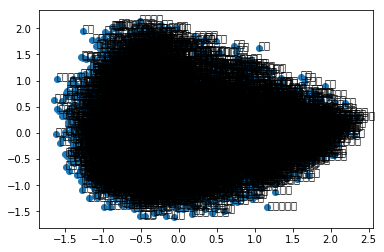

In [52]:
#x=new_model[new_model.wv.vocab]
#pca = PCA(n_components=2)
#result = pca.fit_transform(x)
#pyplot.scatter(result[:, 0], result[:, 1])
#words = list(new_model.wv.vocab)
#for i, word in enumerate(words):
    #pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
#pyplot.show()
#단어가 넘 많음 추후에 몇개 단어만 추려서

In [ ]:
# Doc to vec tsne 2차원
# 시간 오래걸림 내노트북에서 2시간30분

In [21]:
model_loaded.docvecs
tsne_model = TSNE(n_components=2, random_state=0, verbose = 1, init= "pca", method = "exact")
tsne_2D = tsne_model.fit_transform(model_loaded.docvecs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 7174
[t-SNE] Computed conditional probabilities for sample 2000 / 7174
[t-SNE] Computed conditional probabilities for sample 3000 / 7174
[t-SNE] Computed conditional probabilities for sample 4000 / 7174
[t-SNE] Computed conditional probabilities for sample 5000 / 7174
[t-SNE] Computed conditional probabilities for sample 6000 / 7174
[t-SNE] Computed conditional probabilities for sample 7000 / 7174
[t-SNE] Computed conditional probabilities for sample 7174 / 7174
[t-SNE] Mean sigma: 2.556107
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.949819
[t-SNE] Error after 1000 iterations: 3.201086


In [13]:
len(model_loaded.docvecs)

6726

# Doc2vec 으로 K means

In [ ]:
#우리 근데 왜 문서가 7174개이지?

In [14]:
#전체 문서 7174개의 모든 콤비네이션으로 유사도를 계산해서
# 분포로 나타냄 mean0.2
cosine_similarities = []
for r in range(len(model_loaded.docvecs)):
    for t in range(r+1,6726):
        cosine_similarities.append(model_loaded.docvecs.similarity(r,t))

In [16]:
len(cosine_similarities)

22616175

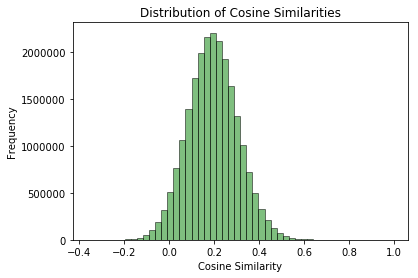

In [19]:
plt.hist(cosine_similarities, 50, facecolor='green', alpha=0.5,ec="black")
plt.title('Distribution of Cosine Similarities')
plt.ylabel('Frequency')
plt.xlabel('Cosine Similarity')
plt.show()

In [20]:
def string_to_digit(string):
    digit = []
    for r in string:
        if r.isdigit():
            digit.append(r)
    return int(''.join(digit))

In [21]:
#문서당 가장 높은 유사도를 가진 문서 뽑기
top_scores = []
for vec in range(len(model_loaded.docvecs)):
    top = model_loaded.docvecs.most_similar(vec, topn = 1)
    top_scores.append((vec, string_to_digit(top[0][0]), top[0][1]))

In [22]:
len(top_scores)

6726

In [55]:
top_sorted = sorted(top_scores, key = itemgetter(2), reverse = True)
first = top_sorted[:6726]
first_doc = []
for k,v,w in first:
    first_doc.append(k)

In [56]:
top_sorted

[(132, 147074, 0.9922096729278564),
 (6513, 147732, 0.9922096729278564),
 (5096, 143587, 0.991572916507721),
 (4958, 143925, 0.9915728569030762),
 (3487, 142645, 0.9912185072898865),
 (4615, 139196, 0.9912185072898865),
 (318, 99980, 0.9904619455337524),
 (933, 164415, 0.9904619455337524),
 (4781, 143525, 0.9902710318565369),
 (4920, 93988, 0.9902710318565369),
 (1057, 166326, 0.9884027242660522),
 (1399, 149349, 0.9884026050567627),
 (4369, 79473, 0.9881306290626526),
 (5489, 142064, 0.9881305694580078),
 (5592, 145533, 0.9880092144012451),
 (5730, 145229, 0.9880092144012451),
 (2477, 167171, 0.9877461194992065),
 (3558, 102663, 0.9877461194992065),
 (5595, 145543, 0.9869805574417114),
 (5738, 145243, 0.9869805574417114),
 (3804, 147074, 0.9867482781410217),
 (6433, 147472, 0.9866740107536316),
 (4, 146932, 0.9866739511489868),
 (5770, 65428, 0.9859926700592041),
 (6657, 96497, 0.9859923720359802),
 (5088, 117334, 0.9858902096748352),
 (6442, 160271, 0.9858902096748352),
 (3, 146930, 

In [57]:
first_doc

[5297,
 5448,
 139,
 6953,
 4677,
 5870,
 2925,
 3715,
 338,
 999,
 5438,
 6879,
 5112,
 5259,
 2611,
 3793,
 3659,
 5196,
 2123,
 5722,
 5977,
 6120,
 6161,
 7101,
 5098,
 5260,
 4056,
 4429,
 4709,
 2,
 6862,
 2269,
 6867,
 3,
 1710,
 4681,
 5290,
 5181,
 4390,
 4523,
 4710,
 6037,
 5979,
 6127,
 7044,
 688,
 1125,
 6337,
 4,
 6869,
 5037,
 5371,
 4683,
 6011,
 5978,
 6131,
 4066,
 5752,
 6119,
 5976,
 4665,
 170,
 464,
 7074,
 6863,
 0,
 803,
 6520,
 4435,
 5041,
 63,
 6195,
 6771,
 1029,
 6340,
 1120,
 2213,
 2338,
 5973,
 6117,
 2752,
 842,
 538,
 4213,
 5816,
 5261,
 2860,
 5764,
 1662,
 4842,
 1285,
 4715,
 2178,
 6639,
 3730,
 4191,
 4702,
 5255,
 5792,
 6440,
 5084,
 5873,
 6130,
 1873,
 6010,
 4106,
 457,
 5981,
 3493,
 6951,
 4727,
 5435,
 3402,
 4380,
 5583,
 1,
 1086,
 6079,
 4267,
 608,
 6536,
 2631,
 5206,
 3327,
 6928,
 1325,
 5291,
 4389,
 4997,
 6114,
 7071,
 4440,
 5158,
 2573,
 5023,
 6697,
 1733,
 6477,
 6476,
 3903,
 1185,
 2299,
 2263,
 4714,
 6031,
 1511,
 3026,

In [29]:
tsne_model = TSNE(n_components=2, random_state=0, verbose = 1, init= "pca", method = "exact")
tsne_3D = tsne_model.fit_transform(model_loaded.docvecs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 6726
[t-SNE] Computed conditional probabilities for sample 2000 / 6726
[t-SNE] Computed conditional probabilities for sample 3000 / 6726
[t-SNE] Computed conditional probabilities for sample 4000 / 6726
[t-SNE] Computed conditional probabilities for sample 5000 / 6726
[t-SNE] Computed conditional probabilities for sample 6000 / 6726
[t-SNE] Computed conditional probabilities for sample 6726 / 6726
[t-SNE] Mean sigma: 2.551198
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.752277
[t-SNE] Error after 1000 iterations: 3.109174


In [31]:
kmeans = KMeans(10, n_jobs=-1)
top_cluster_results = kmeans.fit_predict(tsne_3D[first_doc])

In [32]:
len(top_cluster_results)

6726

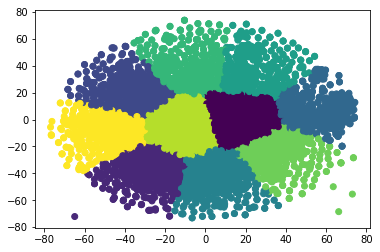

In [34]:
plt.scatter([x[0] for x in tsne_3D[first_doc]], [x[1] for x in tsne_3D[first_doc]], c=top_cluster_results)
plt.show()

In [112]:
stopword = ["피고인","원심","상고","이유","판단","법률","사실","판결","인정","사건","대한","피해자","공소","행위","선고","증거"
           ,"위법","주장"]
data = []
for k,v in dict.items(reason):
    contents2 =[]
    for i in v:
        if ("Noun" in i) and (i[0] not in stopword) :
            contents2.append(i[0])
    data.append(contents2)    

In [105]:
data[0]

['실효',
 '호로',
 '개정',
 '전의',
 '이하',
 '누구',
 '경우',
 '용도',
 '사용',
 '목적',
 '범죄',
 '경력',
 '자료',
 '수사',
 '경력',
 '자료',
 '이하',
 '범죄',
 '경력',
 '자료',
 '취득',
 '규정',
 '위반',
 '범죄',
 '경력',
 '자료',
 '취득',
 '처벌',
 '전과',
 '기록',
 '수사',
 '자료',
 '관리',
 '실효',
 '기준',
 '전과자',
 '정상',
 '사회',
 '복귀',
 '보장',
 '입법',
 '목적',
 '범죄',
 '경력',
 '자료',
 '법령',
 '규정',
 '용도',
 '사용',
 '주체',
 '항의',
 '규정',
 '범죄',
 '경력',
 '자료',
 '회보',
 '취득',
 '자로',
 '한정',
 '위반',
 '범죄',
 '경력',
 '자료',
 '취득',
 '자가',
 '법령',
 '규정',
 '용도',
 '범죄',
 '경력',
 '자료',
 '사용',
 '경우',
 '별도',
 '처벌',
 '종합',
 '범죄',
 '경력',
 '자료',
 '취득',
 '수사',
 '자료',
 '관리',
 '사람',
 '직무',
 '수사',
 '자료',
 '범죄',
 '경력',
 '조회',
 '사람',
 '직접',
 '취득',
 '경우',
 '한정',
 '법리',
 '기록',
 '채용',
 '증거',
 '종합',
 '규정',
 '용도',
 '사용',
 '목적',
 '정화',
 '휴대폰',
 '촬영',
 '출력',
 '고소',
 '범죄',
 '경력',
 '조회',
 '영인본',
 '취득',
 '행위',
 '유죄',
 '정당',
 '거기',
 '주장',
 '법리',
 '오해',
 '논리',
 '경험',
 '법칙',
 '배하',
 '자유',
 '심증',
 '주의',
 '한계',
 '위법',
 '형사소송법',
 '사형',
 '무기',
 '이상',
 '징역',
 '금고',
 '선고',
 '사건',
 '양형',
 '부당',
 '사유',
 '허용',


In [78]:
count = 0
five_clusters = {}
for clust in range(19):
    five_clusters[clust] = []
for r in top_cluster_results:
    five_clusters[r].append(count)
    count += 1

In [79]:
def get_clusters(cluster, keywords_1000):
    return_cluster= {}
    for idx in cluster:
        for keyword in keywords_1000[idx]:
            if keyword in return_cluster:
                return_cluster[keyword] += 1
            else:
                return_cluster[keyword] = 1
    return return_cluster

def order_cluster(cluster):
    temp = []
    for k, v in sorted(cluster.items(), key = itemgetter(1), reverse = True):
        temp.append((k,v))
    return temp[:10]



In [113]:
cluster_0 = get_clusters(five_clusters[0], data)
cluster_1 = get_clusters(five_clusters[1], data)
cluster_2 = get_clusters(five_clusters[2], data)
cluster_3 = get_clusters(five_clusters[3], data)
cluster_4 = get_clusters(five_clusters[4], data)

In [114]:
print(order_cluster(cluster_0))
print(order_cluster(cluster_1))
print(order_cluster(cluster_2))
print(order_cluster(cluster_3))
print(order_cluster(cluster_4))
print(cluster_3)

[('진술', 2175), ('부분', 1881), ('기록', 1813), ('법리', 1808), ('경우', 1768), ('범죄', 1730), ('위반', 1396), ('오해', 1307), ('기재', 1249), ('범행', 1240)]
[('기록', 1195), ('부분', 1113), ('법리', 1024), ('범죄', 1013), ('경우', 979), ('진술', 970), ('위반', 813), ('오해', 804), ('검사', 728), ('기재', 702)]
[('진술', 1625), ('기록', 1461), ('부분', 1403), ('법리', 1218), ('경우', 1123), ('범죄', 1064), ('기재', 972), ('위반', 945), ('오해', 892), ('정당', 860)]
[('기록', 1355), ('진술', 1354), ('부분', 1292), ('경우', 1248), ('법리', 1158), ('위반', 1079), ('범죄', 1048), ('기재', 920), ('규정', 895), ('정당', 881)]
[('진술', 1382), ('부분', 1302), ('기록', 1202), ('범죄', 1199), ('법리', 1180), ('경우', 1165), ('위반', 995), ('오해', 874), ('기재', 849), ('검사', 783)]
{'박영미': 2, '수집': 34, '보조': 36, '보증인': 8, '판단력': 3, '곽이홍': 1, '전창': 1, '김윤호': 1, '포장': 2, '승가': 2, '착취': 3, '듀스': 1, '김전': 3, '미수': 59, '주업': 4, '백의': 11, '중독증': 4, '팔면': 1, '외환은행': 3, '날짜': 7, '존속': 13, '두절': 1, '분식': 4, '계약서': 121, '지금': 5, '연구': 20, '성일': 2, '갑상선암': 1, '이남순': 6, '수원지방검찰청': 1, '사동': 1, '안전보장':